In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../../src')

In [3]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [217]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')


adata.obs = adata.obs.join(pd.read_csv('banksy_celltypes.csv', index_col=0))
adata.obs['cell_type'] =  adata.obs['cell_type'].astype(str).copy()
adata.obs.loc[adata.obs['cell_type'] == 'GC B', 'cell_type'] = adata.obs['banksy_celltypes']
adata.obs.cell_type = adata.obs.cell_type.replace(
    {'T_CD4': 'CD4+ T', 'plasma': 'Plasma', 'B_memory': 'B memory', 'B_naive': 'B naive'})
adata = adata[~adata.obs.cell_type.isin(['Macrophages', 'FDC'])]
adata = adata[~adata.obs.cell_type_2.isin(['DN T', 'pDC', 'mDC', 'fDC'])]

adata = adata[adata.obs.cell_type.str.contains('GC')]

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
xy = xy_from_adata(adata)
adata.obs.cell_type.value_counts()

cell_type
GC Light Zone           598
GC Dark Zone            534
GC Intermediate Zone    418
Name: count, dtype: int64

In [235]:
color_dict = {
    # 'CD4+ T': "#ea7465",
    # 'Tfh': "#b74329", 
    # 'CD8+ T': "#dd3652",
    # 'T cells': "#7a4711",
    'GC Intermediate Zone': "#e28723",
    'GC Dark Zone': "#147ee9",
    'GC Light Zone': "#f309c5",
    # 'GC B': "#6a064f",
    # 'B memory': "#61c17c",
    # 'B naive': "#4b9131", 
    # 'Plasma': "#beb637",
    # 'T memory': "#98907f",
}

In [236]:
chart = Cartography(adata, color_dict)

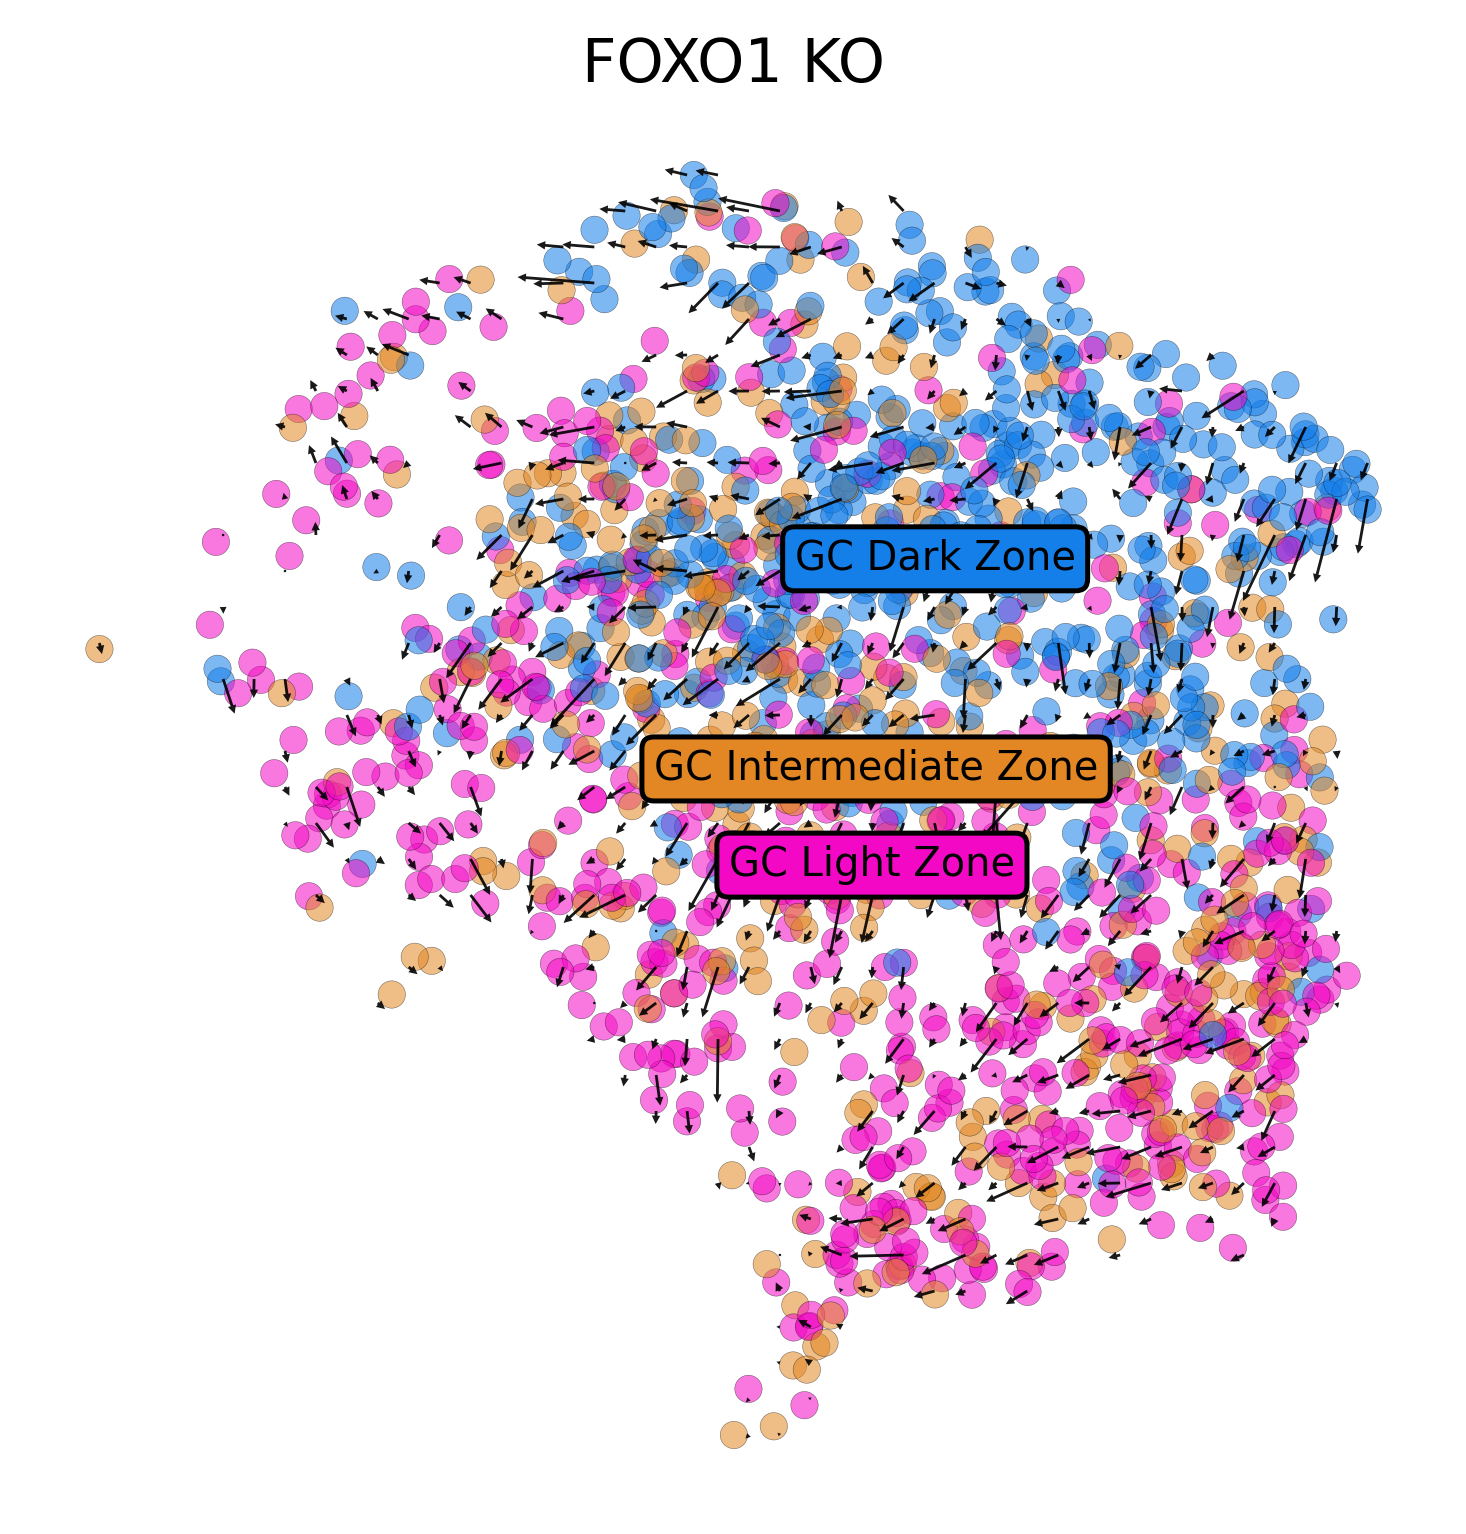

In [237]:
kotarget = 'FOXO1'
grid, vec = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=1,
    vector_scale=0.15,
    n_neighbors=70,
    figsize=(5, 5), 
    hue='cell_type',
    alpha=0.55,
    scatter_size=30,
    remove_null=True,
    betadata_path='/Volumes/SSD/genome_screens/human_tonsil',
    legend_on_loc=True,
)
plt.title(f'{kotarget} KO')
plt.show()

In [238]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.transforms import Affine2D

In [242]:
chart.adata.obs['cell_type'].value_counts()

cell_type
GC Light Zone           598
GC Dark Zone            534
GC Intermediate Zone    418
Name: count, dtype: int64

In [263]:
from sklearn.neighbors import KDTree

def get_vector_field_strength(xy_coords, grid_points, vector_field):
    grid_magnitudes = np.linalg.norm(vector_field, axis=1)
    grid_angles = np.arctan2(vector_field[:, 1], vector_field[:, 0])
    tree = KDTree(grid_points)
    _, indices = tree.query(xy_coords)
    strengths = grid_magnitudes[indices]
    angles = grid_angles[indices]
    
    return strengths, angles


def plot_quiver(grid_points, vector_field, r=0.1, base=0.01, quiver=True):

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

    magnitudes = np.linalg.norm(vector_field, axis=1)
    indices = magnitudes > 0
    grid_points = grid_points[indices]
    vector_field = vector_field[indices]
    
    X = chart.adata.obsm['X_umap'][:, :]
    cell_types = chart.adata.obs['cell_type']
    

    magg, angles = get_vector_field_strength(adata.obsm['X_umap'], grid, vec)
    min_mag = np.min(magg)
    max_mag = np.max(magg)
    
    for i in range(len(X)):
        x, y = X[i]
        fig = plt.gcf()
        ax = plt.gca()
        
        mag = magg[i]
        angle = angles[i]
        cell_type = cell_types[i]
        mag_norm = base + (mag - min_mag) * (5 - base) / (max_mag - min_mag)
        
        gradient = np.random.beta(1, mag_norm, size=(256, 1))
        gradient.sort(axis=0)
        
        if cell_type == 'GC Dark Zone':
            color_from = color_dict['GC Dark Zone']
            color_to = color_dict['GC Light Zone']
        elif cell_type == 'GC Light Zone':
            color_from  = "#73065d"
            color_to = "#f309c5"

        elif cell_type == 'GC Intermediate Zone':
            color_from = color_dict['GC Intermediate Zone']
            color_to = color_dict['GC Light Zone']
            
        img = ax.imshow(gradient,
                        cmap=LinearSegmentedColormap.from_list('custom', [
                            color_to, color_from]),
                        extent=[x-r, x+r, y-r, y+r],
                        transform=Affine2D().rotate_around(x, y, angle + np.pi/2) + ax.transData
                        )
        
        circle = plt.Circle((x, y), r, transform=ax.transData)
        img.set_clip_path(circle)

    ax.quiver(
        grid_points[:, 0], grid_points[:, 1],   
        vector_field[:, 0], vector_field[:, 1], 
        angles='xy', scale_units='xy', scale=1, 
        headwidth=3, headlength=3, headaxislength=3,
        width=0.002, alpha=0.9 if quiver else 0
    )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_axis_off()

    if ax is not None:
        return ax
    

In [1]:
# plot_quiver(grid, vec, r=0.08, quiver=True)
# plt.title('FOXO1 KO')
# plt.show()

In [25]:
ligands = ['IL7', 'IL4',  'IL6ST', 'GZMA']
receptors = ['CXCR4', 'CXCL12', 'CCR2', 'IL7R']
tf = ['GATA3', 'PAX5', 'FOXP3', 'BCL6', 'TBX21', 'PRDM1']

In [26]:
for i in ligands+receptors+tf:
    if i not in adata.var_names:
        print(i)

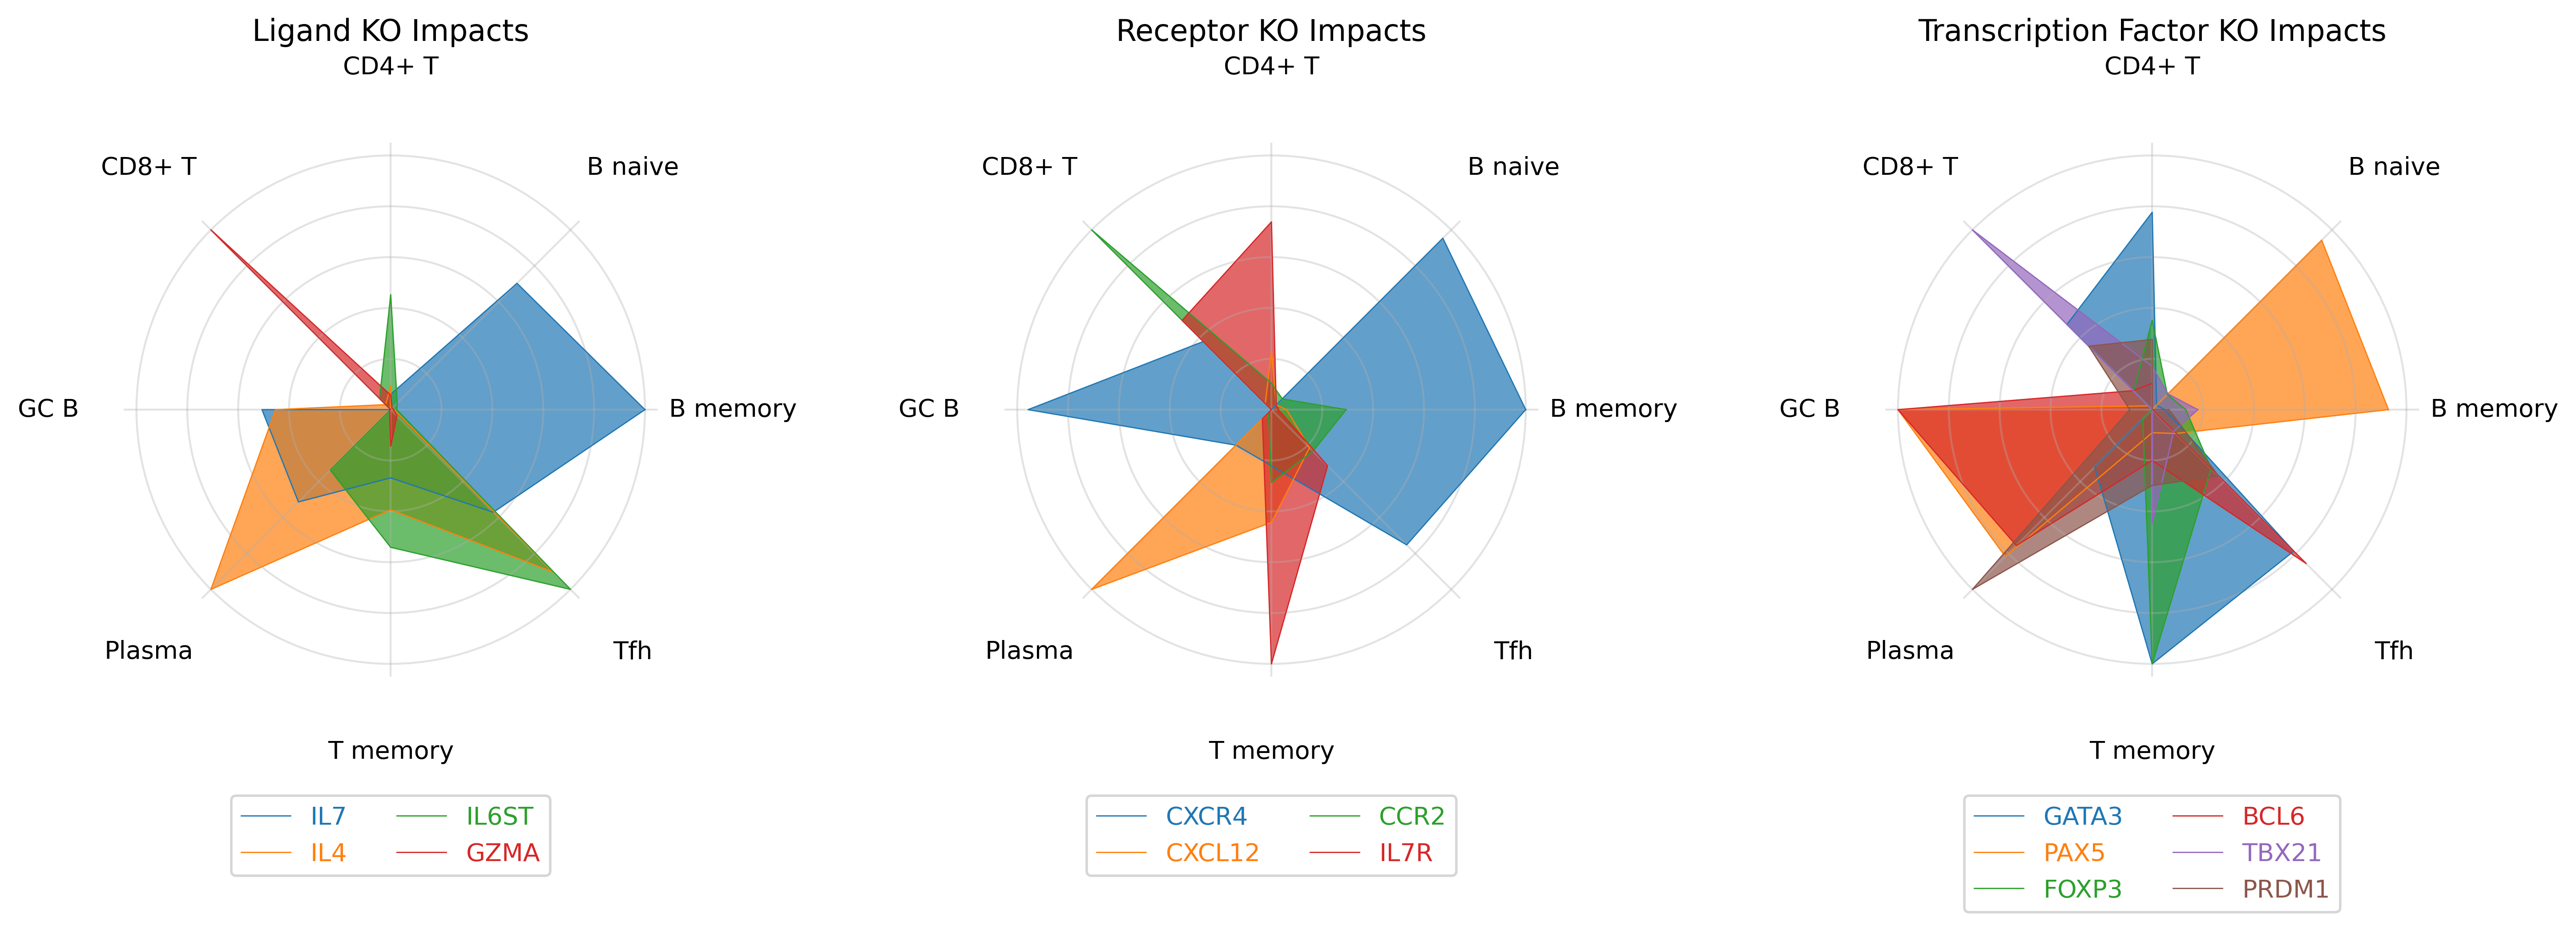

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200, subplot_kw={'projection': 'polar'})

# Helper function to plot radar chart
def plot_radar(kotargets, ax, title):
    for kotarget in kotargets:
        data = (pd.read_parquet(
            f'/Volumes/SSD/genome_screens/human_tonsil/{kotarget}_4n_0x.parquet').loc[
                chart.adata.obs_names
            ]-chart.adata.to_df(layer='imputed_count')
            ).join(chart.adata.obs.cell_type_2).groupby(
                'cell_type_2'
            ).mean().abs().mean(axis=1)
        
        # Normalize values between 0 and 1
        data = (data - data.min()) / (data.max() - data.min())

        # Prepare data for radar plot
        categories = data.index.tolist()
        values = data.values.tolist()
        values += values[:1] # Repeat first value to close the polygon
        angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
        angles = np.concatenate((angles, [angles[0]])) # Repeat first angle to close the polygon

        # Plot data
        ax.plot(angles, values, '-', linewidth=0.5, label=kotarget)
        ax.fill(angles, values, alpha=0.7)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    ax.tick_params(pad=20)
    ax.set_yticklabels([])
    ax.grid(True, alpha=0.35)
    ax.spines['polar'].set_visible(False)
    ax.set_title(title)
    legend = ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2, markerscale=1)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())

plot_radar(ligands, axs[0], 'Ligand KO Impacts')
plot_radar(receptors, axs[1], 'Receptor KO Impacts')
plot_radar(tf, axs[2], 'Transcription Factor KO Impacts')

plt.tight_layout()
plt.show()

In [4]:
# ko_screen = []
# for kodf in tqdm(list(glob.glob('/Volumes/SSD/genome_screens/human_tonsil/*.parquet'))):
#     data = (pd.read_parquet(kodf).loc[
#             chart.adata.obs_names
#         ]-chart.adata.to_df(layer='imputed_count')
#         ).join(chart.adata.obs.cell_type_2).groupby(
#             'cell_type_2'
#         ).mean().abs().mean(axis=1).sort_values(
#             ascending=True
#         )
        
#     data = data.to_frame()
#     data.columns = [kodf.split('/')[-1].split('_')[0]]
    
#     ko_screen.append(data)

In [2]:
# import matplotlib.pyplot as plt
# import random

# unique_cell_types = adata.obs.cell_type_2.unique()
# fig, axs = plt.subplots(2, 4, figsize=(20, 10), dpi=200)
# for i, cell_type in enumerate(unique_cell_types):
#     row, col = divmod(i, 4)
#     colors = [random.choice(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(6)]) for _ in range(20)]
#     axs[row, col].barh(pd.concat(ko_screen, axis=1).loc[cell_type].sort_values(ascending=False).head(20).index, 
#                        pd.concat(ko_screen, axis=1).loc[cell_type].sort_values(ascending=False).head(20).values, 
#                        color=colors, linewidth=1, edgecolor='black')
#     axs[row, col].set_title(cell_type)
#     axs[row, col].invert_yaxis()
#     axs[row, col].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.tight_layout()
# plt.show()

In [3]:
# kotarget = 'GATA3'
# data = (pd.read_parquet(
#     f'/Volumes/SSD/genome_screens/human_tonsil/{kotarget}_4n_0x.parquet').loc[
#         chart.adata.obs_names
#     ]-chart.adata.to_df(layer='imputed_count')
#     ).join(chart.adata.obs.cell_type_2).groupby(
#         'cell_type_2'
#     ).mean().abs().mean(axis=1).sort_values(
#         ascending=True
#     )

# plt.figure(figsize=(6, 4), dpi=100)
# sns.barplot(
#     x=data.values,
#     y=data.index,
#     edgecolor='black',
#     palette=color_dict,
#     linewidth=2,
#     order=data.index[::-1],
# )

# plt.xlabel('Mean Expression')
# plt.ylabel('Cell Type')
# plt.title(f'{kotarget} KO Impact by Cell Type')

# sns.despine(offset=5)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.tight_layout()
# plt.show()

In [6]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')

adata.obs = adata.obs.join(pd.read_csv('banksy_celltypes.csv', index_col=0))
adata.obs['cell_type'] =  adata.obs['cell_type'].astype(str).copy()
adata.obs.loc[adata.obs['cell_type'] == 'GC B', 'cell_type'] = adata.obs['banksy_celltypes']
adata.obs.cell_type = adata.obs.cell_type.replace(
    {'T_CD4': 'CD4+ T', 'plasma': 'Plasma', 'B_memory': 'B memory', 'B_naive': 'B naive'})
adata = adata[~adata.obs.cell_type.isin(['Macrophages', 'FDC'])]
adata = adata[~adata.obs.cell_type_2.isin(['DN T', 'pDC', 'mDC', 'fDC'])]
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_48172/2412879108.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')


In [4]:
color_dict = {
    'CD4+ T': "#ea7465",
    'Tfh': "#b74329", 
    'CD8+ T': "#dd3652",
    'T cells': "#7a4711",
    'GC Intermediate Zone': "#e28723",
    'GC Dark Zone': "#147ee9",
    'GC Light Zone': "#f309c5",
    'GC B': "#6a064f",
    'B memory': "#61c17c",
    'B naive': "#4b9131", 
    'Plasma': "#beb637",
    'T memory': "#98907f",
}

In [7]:
chart = Cartography(adata, color_dict)

In [75]:
from spaceoracle.plotting.shift import estimate_transition_probabilities
kotarget = 'FOXO1'
embedding = adata.obsm['X_umap']
# embedding = adata.obsm['spatial']
n_neighbors = 100
betadata_path = '/Volumes/SSD/genome_screens/human_tonsil'
perturbed_df = pd.read_parquet(
    f'{betadata_path}/{kotarget}_4n_0x.parquet')
delta_X = perturbed_df.loc[
    chart.adata.obs_names].values - chart.adata.layers['imputed_count']
chart.adata.layers[kotarget] = perturbed_df.loc[chart.adata.obs_names].values.copy()
corr = chart.get_corr(kotarget)
# P = estimate_transition_probabilities(
#     adata, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)

# P_null = estimate_transition_probabilities(
#     adata, delta_X * 0, embedding, n_neighbors=n_neighbors, n_jobs=1)

# P = P - P_null

# P = (P - P.min()) / (P.max() - P.min())
# P = P / P.sum(axis=1)[:, np.newaxis]

del chart.adata.layers[kotarget]
chart.adata.obs

cell_type   author_cell_type cell_type_int leiden  \
GC Dark Zone                                                                
AAACCCAAGCGCCTTG-1        T cells              T_CD4             7      0   
AAACCCAAGTGGACGT-1         Plasma             plasma             6      4   
AAACCCACAGAAGTGC-1  GC Light Zone  B_germinal_center             4      5   
AAACCCATCATCGCAA-1       B memory           B_memory             0      7   
AAACCCATCCGATCGG-1         Plasma  B_germinal_center             6      4   
...                           ...                ...           ...    ...   
TTTGTTGCAGGGACTA-1   GC Dark Zone  B_germinal_center             4      5   
TTTGTTGCATTGTAGC-1         Plasma             plasma             6      4   
TTTGTTGGTACCACGC-1   GC Dark Zone  B_germinal_center             4      5   
TTTGTTGGTCTGTCCT-1         CD4+ T              T_CD4             2      2   
TTTGTTGTCATGCGGC-1         CD4+ T              T_CD4             2      2   

                   leiden_R cell_type_2      banksy_celltypes     transition  
GC Dark Zone                                                                  
AAACCCAAGCGCCTTG-1      0,0    T memory                 T_CD4        T cells  
AAACCCAAGTGGACGT-1        1      Plasma                plasma         Plasma  
AAACCCACAGAAGTGC-1        2        GC B         GC Light Zone  GC Light Zone  
AAACCCATCATCGCAA-1        4    B memory              B_memory       B memory  
AAACCCATCCGATCGG-1        1      Plasma  GC Intermediate Zone         Plasma  
...                     ...         ...                   ...            ...  
TTTGTTGCAGGGACTA-1        2        GC B          GC Dark Zone  GC Light Zone  
TTTGTTGCATTGTAGC-1        1      Plasma                plasma         Plasma  
TTTGTTGGTACCACGC-1        2        GC B          GC Dark Zone  GC Light Zone  
TTTGTTGGTCTGTCCT-1      0,2      CD4+ T                 T_CD4         CD4+ T  
TTTGTTGTCATGCGGC-1      0,2      CD4+ T                 T_CD4         CD4+ T  

[5135 rows x 8 columns]

In [77]:
corr_null = chart.compute_perturbation_corr(
    chart.adata.to_df(layer='imputed_count'), delta_X*0)

In [84]:
source_ct = 'GC Dark Zone'
# transition_df = chart.compute_transitions(corr, source_ct=source_ct, annot='cell_type')
n_cells = chart.adata.shape[0]
P = np.ones((n_cells, n_cells))
T = 0.05
np.fill_diagonal(P, 0)
P *= np.exp(corr / T)   
P /= P.sum(1)[:, None]

P_null = np.ones((n_cells, n_cells))
np.fill_diagonal(P_null, 0)
P_null *= np.exp(corr_null / T)   
P_null /= P_null.sum(1)[:, None]
P = P - P_null

# P = (P - P.min()) / (P.max() - P.min())
# P = P / P.sum(axis=1)[:, np.newaxis]

transition_df = pd.DataFrame(P[chart.adata.obs['cell_type'] == source_ct])
transition_df.columns = chart.adata.obs_names
transition_df.columns.name = source_ct

chart.assess_transitions(
    transition_df, 
    base_celltypes=chart.adata.obs.cell_type, 
    source_ct=source_ct,
    annot='cell_type'
)

Source Cells: GC Dark Zone       min      mean       max
Transition Target                                       
GC Light Zone               0.000421  0.000766  0.001175
GC Intermediate Zone        0.000082  0.000509  0.000780
GC Dark Zone               -0.000190 -0.000024  0.000344
Plasma                     -0.000188 -0.000152  0.000270
B memory                   -0.000193 -0.000184 -0.000098
B naive                    -0.000194 -0.000187 -0.000087
Tfh                        -0.000195 -0.000191 -0.000096
CD4+ T                     -0.000195 -0.000192 -0.000152
T cells                    -0.000195 -0.000193 -0.000139

In [88]:
thresh = 0.000555
allowed_fates = ['GC Light Zone', 'GC Intermediate Zone', 'GC Dark Zone']
transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

Counter({'GC Light Zone': 469, 'GC Intermediate Zone': 63, 'GC Dark Zone': 2}) 0.0006425643821251809


In [21]:
projection_params = {
    'basis': 'spatial',
    'color': 'banksy_celltypes', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.8,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    # 'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.0,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 100,
}

will return


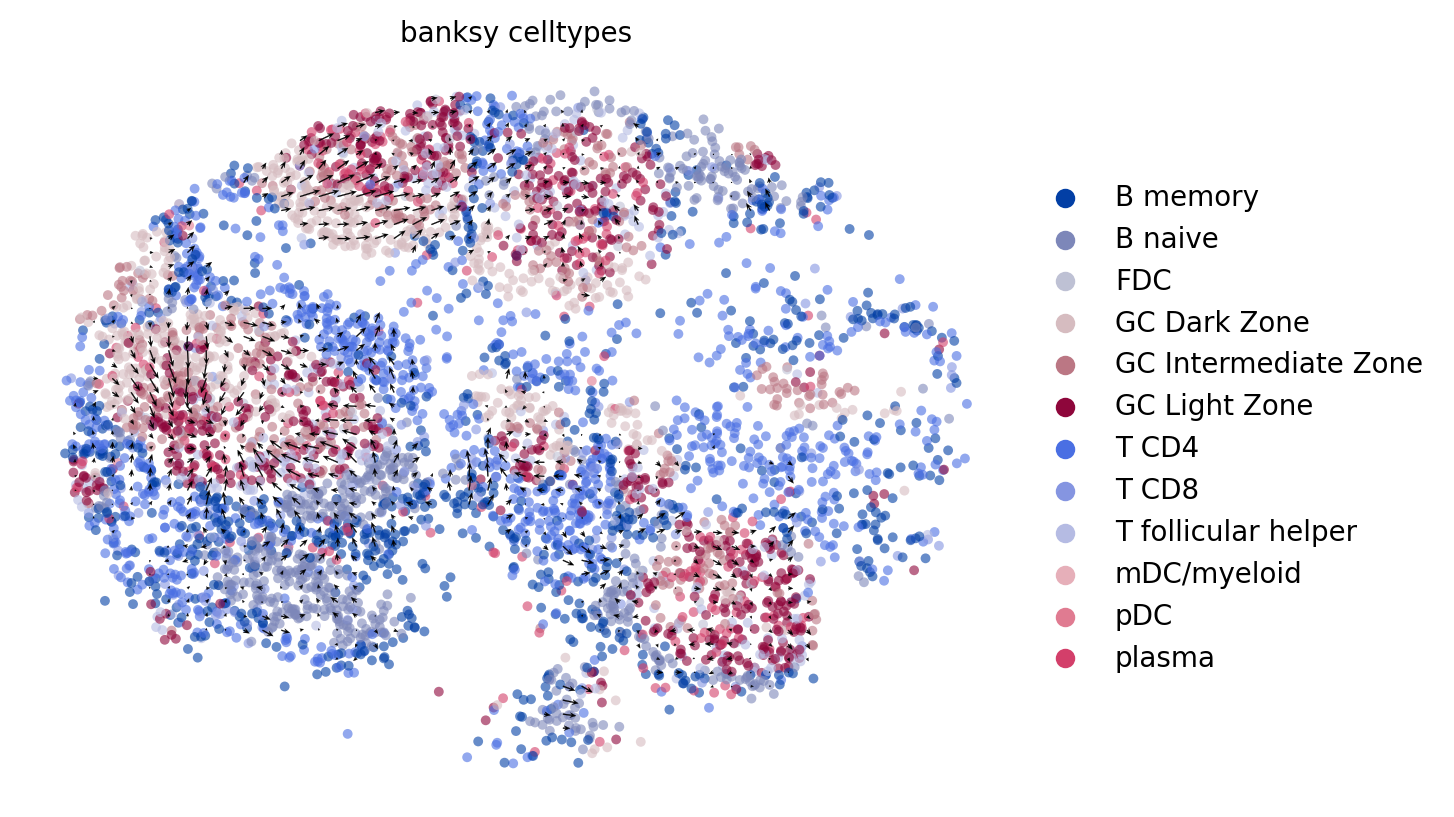

In [22]:
# %%capture
X_grid, V_grid = chart.get_grids(P, projection_params)
vector_field_df = chart.vector_field_df(X_grid, V_grid)

In [39]:
import alphashape

In [42]:
source_cells = adata.obs[adata.obs['cell_type'] == source_ct].index
adata.obs['transition'] = adata.obs['cell_type'].copy()
adata.obs.loc[source_cells, 'transition'] = np.array(transitions)
ct_points_wt, ct_points_ko = chart.make_celltype_dict()

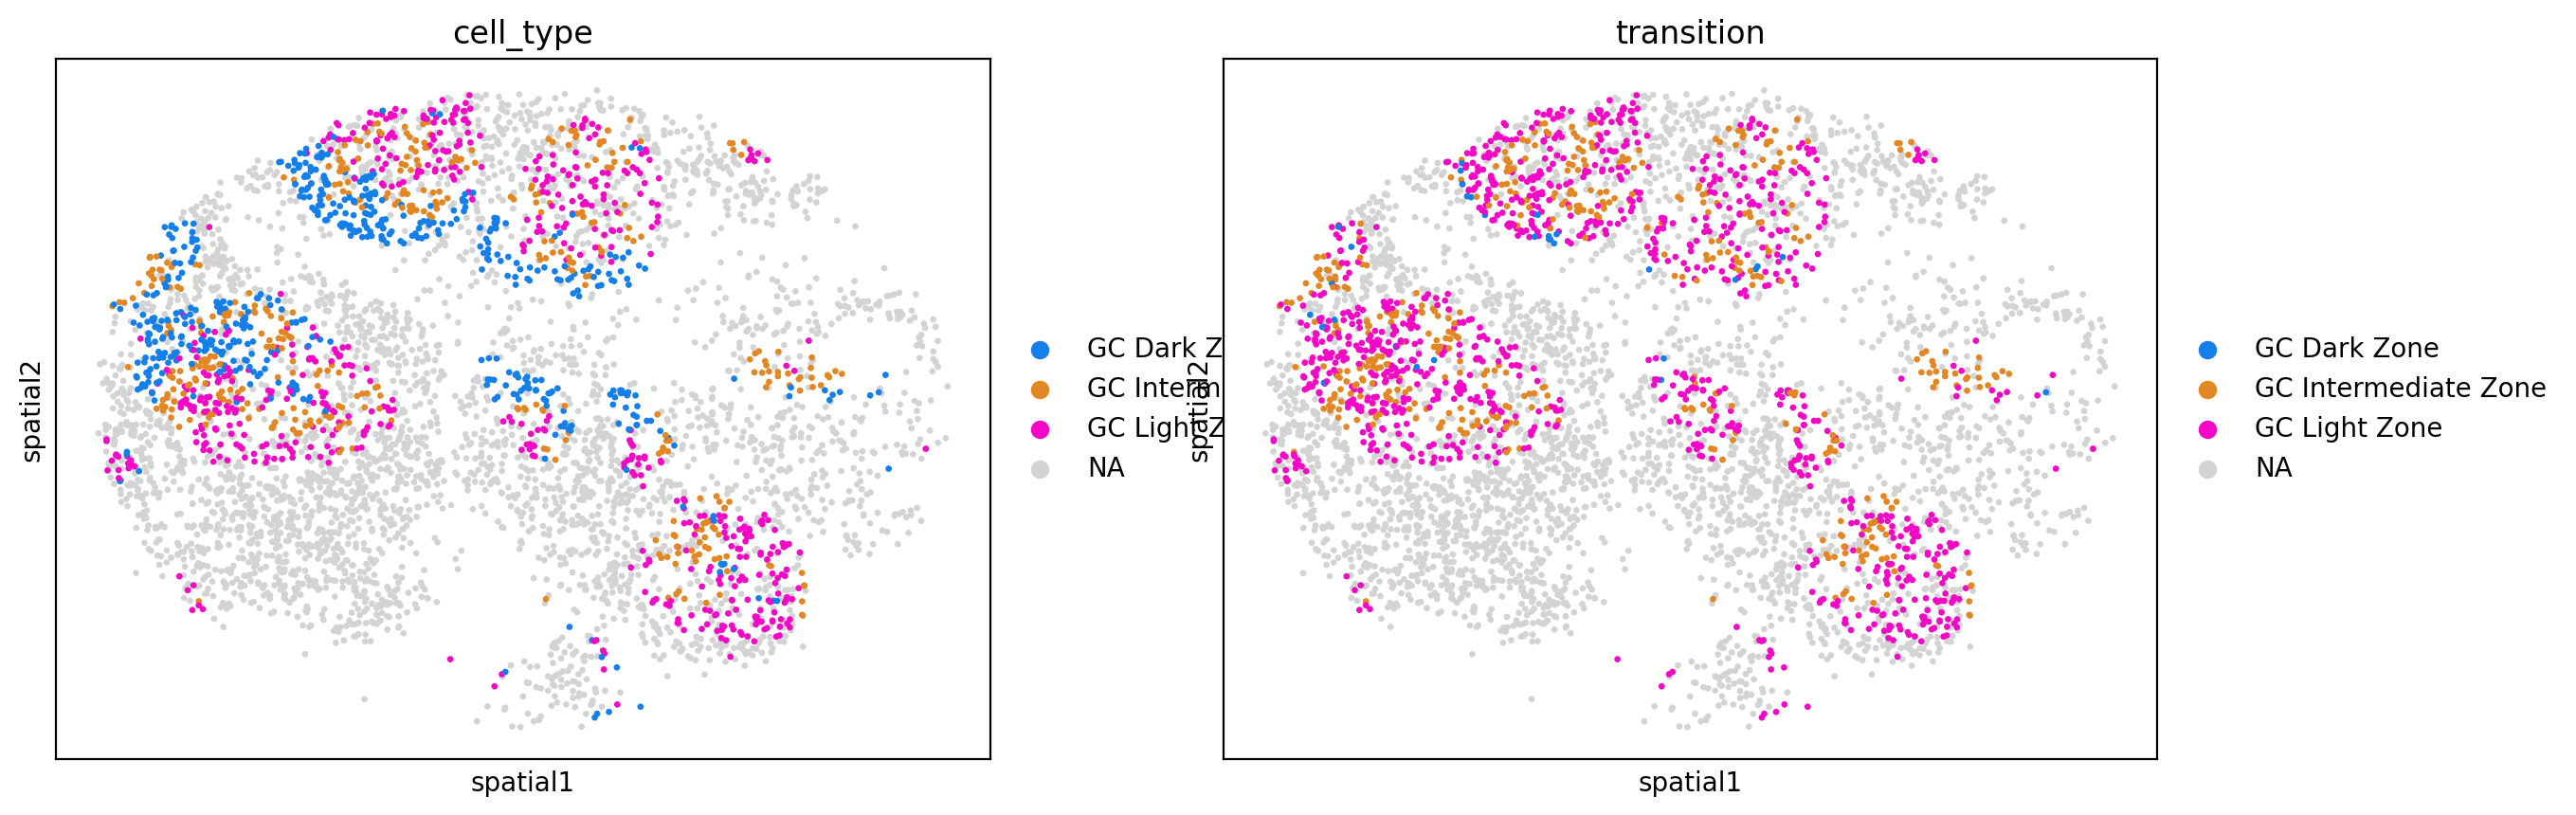

In [57]:
sc.pl.embedding(adata, color=['cell_type', 'transition'], 
    basis='spatial', palette=color_dict, groups=['GC Light Zone', 'GC Dark Zone', 'GC Intermediate Zone'])

In [43]:
delta_df = perturbed_df - adata.to_df(layer='imputed_count')

In [44]:
import alphashape
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.04)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.04)
alpha_shape_3 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.04)

In [45]:
xy = xy_from_adata(adata)

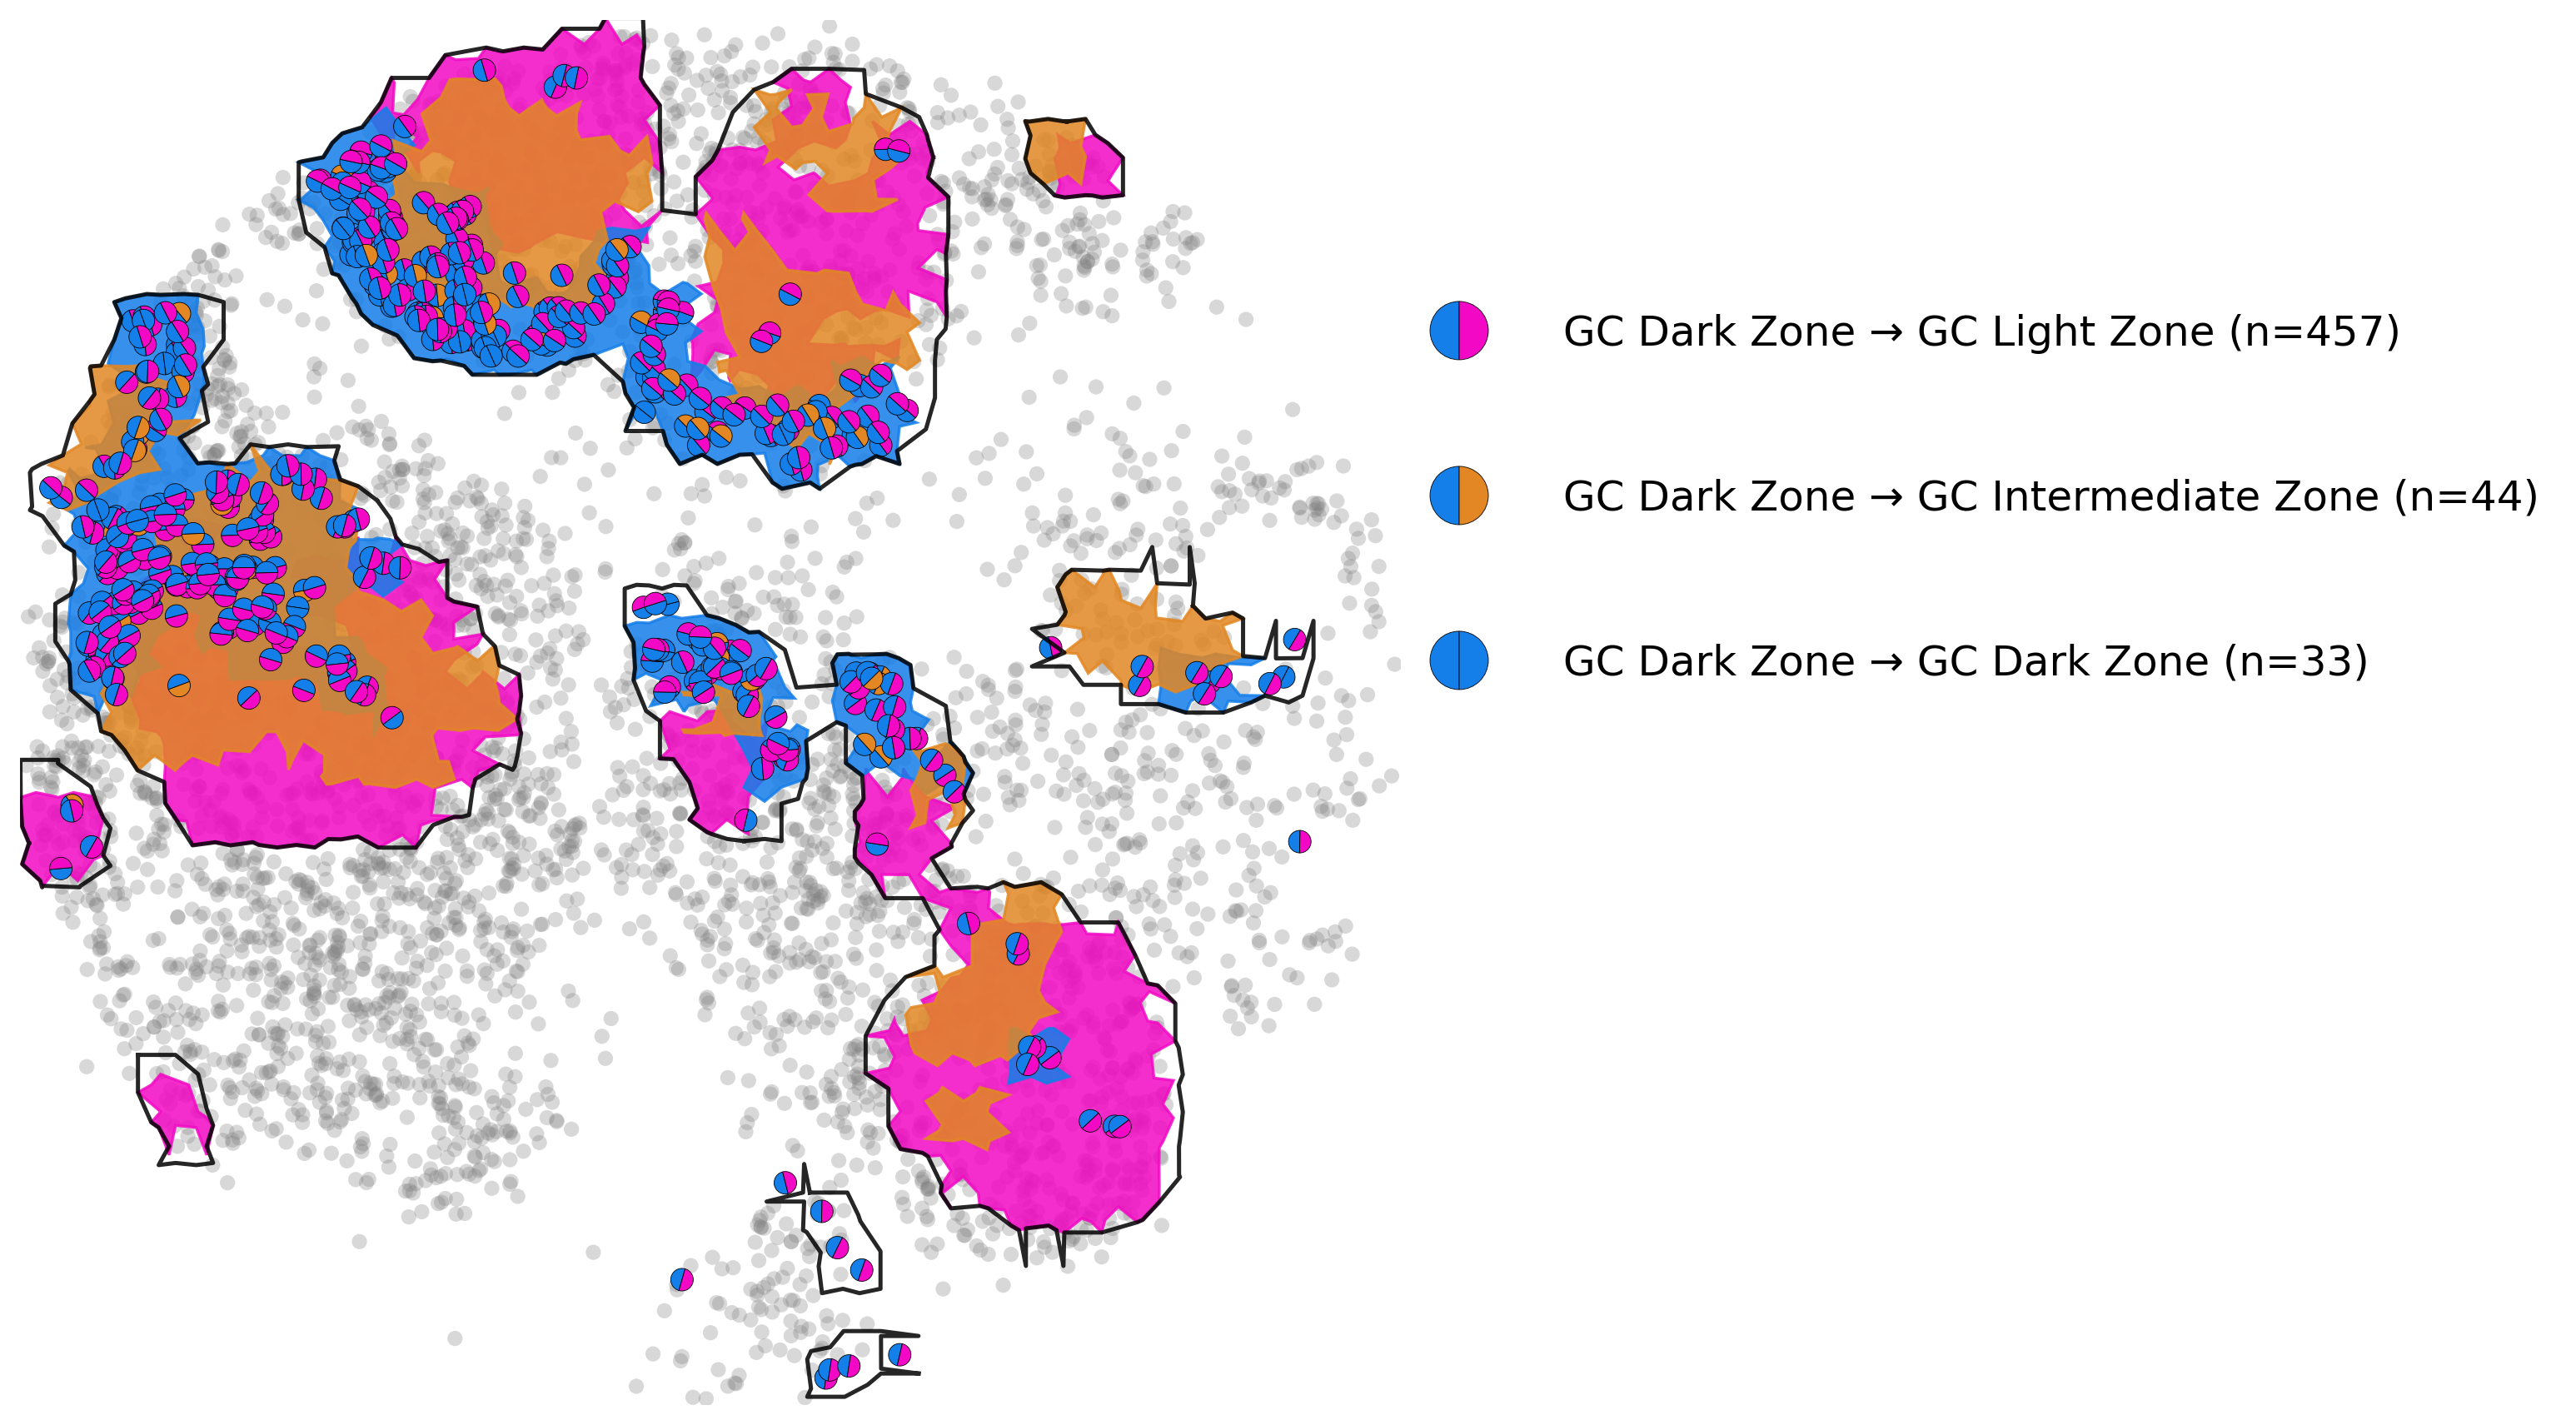

In [46]:
from matplotlib.legend_handler import HandlerTuple
import matplotlib
# Custom handler for wedge pairs in legend
class WedgePairHandler:
    def __init__(self, rotation=0):
        self.rotation = rotation
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        r = min(width, height) * 1
        center = (x0 + width/2, y0 + height/2)
        
        # Create left and right wedges with rotation
        wedge1 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=90 + self.rotation, theta2=270 + self.rotation,
            facecolor=orig_handle[0].get_facecolor(),
            edgecolor='black',
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        wedge2 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=-90 + self.rotation, theta2=90 + self.rotation,
            facecolor=orig_handle[1].get_facecolor(),
            edgecolor='black', 
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        handlebox.add_artist(wedge1)
        handlebox.add_artist(wedge2)
        return [wedge1, wedge2]

fig, ax = plt.subplots(figsize=(20, 9), dpi=120)
data = xy.join(adata.obs)
source_data = data[data.banksy_celltypes == source_ct]
transition_data = data.loc[source_cells]

scatter = sns.scatterplot(
    data=xy.join(adata.obs),
    x='x', y='y',
    # hue='banksy_celltypes', 
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    # palette=color_dict,
    ax=ax,
)



zone_alpha = 0.85
for geom in alpha_shape_1.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

for geom in alpha_shape_2.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Dark Zone'], alpha=zone_alpha)

for geom in alpha_shape_3.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

alpha_shape_4 = alphashape.alphashape(
    np.concatenate(
        [ct_points_wt['GC Light Zone'], 
         ct_points_wt['GC Intermediate Zone'], 
         ct_points_wt['GC Dark Zone']]
        ), alpha=0.03)

for geom in alpha_shape_4.geoms:
    if geom.area > 10000:
        ax.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=zone_alpha)

# Create scatter plot with legend



    
radius = 18

angles = vector_field_df.angle

for idx, row in data.iterrows():
    if idx in source_cells:
        angle = angles[idx]
        circle1 = matplotlib.patches.Wedge((row.x, row.y), radius, 90+angle, 270+angle,
                                         facecolor=color_dict[row.banksy_celltypes],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        circle2 = matplotlib.patches.Wedge((row.x, row.y), radius, -90+angle, 90+angle,
                                         facecolor=color_dict[row.transition],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
    else:
        continue
        circle = plt.Circle((row.x, row.y), radius=radius//1.5,
                          facecolor='grey',
                          alpha=0.5,
                          edgecolor='none') 
        ax.add_patch(circle)
# for ii, jj in edges:
#     ax.plot(
#         points[[ii, jj], 0], 
#         points[[ii, jj], 1], 'k', 
#         linewidth=1, alpha=0.65, 
#         linestyle='--', color='red')

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
ax.set_ylim(data.y.min() - 10, data.y.max() + 10)

# Collect all unique transition types from transition_data
unique_transitions = transition_data['transition'].unique()

# Create legend elements for each transition type
legend_elements = []
labels = []

# Create legend elements with fixed angles for consistent appearance
for transition in unique_transitions:
    # Count number of transitions for this type
    n_transitions = len(transition_data[transition_data['transition'] == transition])
    
    wedge_source = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                          facecolor=color_dict[source_ct])
    wedge_transition = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                              facecolor=color_dict[transition])
    legend_elements.append((wedge_source, wedge_transition))
    labels.append(f"{source_ct} → {transition} (n={n_transitions})")

# Create the transitions legend using custom handler with 45 degree rotation
transition_legend = ax.legend(legend_elements, labels, 
                            handler_map={tuple: WedgePairHandler(rotation=0)},
                            bbox_to_anchor=(1, 0.8), 
                            # loc='center right', 
                            borderaxespad=0.,
                            fontsize=15,
                            markerscale=5,
                            labelspacing=3,
                            handletextpad=1.5, 
                            frameon=False,
                            title="")


# sns.scatterplot(
#     data=vector_field_df.join(adata.obs).query(
#         'cell_type == "B_germinal_center"'), 
#     x='x', y='y', s=50, 
#     hue='banksy_celltypes', palette=color_dict, legend=False, ax=ax)

vecdf = vector_field_df.join(adata.obs).query(
    'banksy_celltypes == "plasma"')

magn = np.sqrt(V_grid[:, 0]**2 + V_grid[:, 1]**2)

# ax.quiver(vecdf['x'], vecdf['y'], 
#           np.cos(np.radians(vecdf['angle'])), 
#           np.sin(np.radians(vecdf['angle'])),
#           scale=25, width=0.002, alpha=0.5)

# q = plt.quiver(X_grid[:, 0], X_grid[:, 1], V_grid[:, 0], V_grid[:, 1],
#             #    magnitudes, 
#                cmap='magma', 
#                linewidth=0.4,
#                scale=1000, width=0.0035, 
#                alpha=0.4, edgecolor=None)

plt.xlabel('')
plt.ylabel('')
plt.title('')

# plt.tight_layout()
# plt.savefig('/tmp/transition_figure.png', dpi=300, format='png')
plt.show()

# scatter_legend = ax.legend(
#     title="Cell Types", bbox_to_anchor=(1.5, -0.0), 
#     loc='lower right', markerscale=2)

# for lh in scatter_legend.legend_handles:
#     lh.set_alpha(1)
# ax.add_artist(scatter_legend)

In [212]:
# fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# data = xy.join(adata.obs)
# source_data = data[data.banksy_celltypes == source_ct]
# transition_data = data.loc[source_cells]

# scatter = sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     # hue='banksy_celltypes', 
#     color='grey',
#     s=30,
#     alpha=0.3,
#     edgecolor='none',
#     # palette=color_dict,
#     ax=ax,
# )

# alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.04)
# alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.04)
# alpha_shape_3 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.04)

# zone_alpha = 0.85
# for geom in alpha_shape_1.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

# for geom in alpha_shape_2.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Dark Zone'], alpha=zone_alpha)

# for geom in alpha_shape_3.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

# alpha_shape_4 = alphashape.alphashape(
#     np.concatenate(
#         [ct_points_wt['GC Light Zone'], 
#          ct_points_wt['GC Intermediate Zone'], 
#          ct_points_wt['GC Dark Zone']]
#         ), alpha=0.03)

# for geom in alpha_shape_4.geoms:
#     if geom.area > 10000:
#         ax.plot(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color='black', alpha=zone_alpha)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
# ax.set_ylim(data.y.min() - 10, data.y.max() + 10)
# plt.show()